-- исходные данные
-- содержательный ли контекст? 
-- контекст сдвигая на одну

-- что за пары? 

-- что значит разная длина? 

-- kmenas

-- какая метрика качества? кластеров? 


-- посчитать н-граммы



РАЗГОВОР С СОФЬЕЙ
- blast для сравнения 
- есть своя кластеризация и uclust, работают по разному. 
- Четкого размера нет
- Для каких-то спейсеров известно, что они в одном кластере, из-за ошибок сиквенирования, с известными центрами 
- важен порядок спейсеров
- читаем пары спейсеров иногда тройки (простая вероятностна модель)
- должна быть вероятность 0.001, но выходит гораздо больше (почему???)
- считаем что похожих нет, бывает два подряд похожих
- что-то еще есть может быть по тем данным которые есть. База данных кассет
- 

In [1]:
f = open('./SlO_spacers_pairs/SlO1_R1_spacers.txt')
lines = f.readlines()
f.close()

In [3]:
lines = lines [1:]

In [5]:
lines[:10]

['CTGTTTTCGCAAATCTATGGACTATTGCTATT\n',
 'CTGCCGACTGACCGCCGACGCTTTCGCGTTAA\n',
 'CCACCTGCCGCGACGGGTGCCAGCAGATCACG\n',
 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG\n',
 'CACACCGTCGCCGGTGCGCGATAACACGTAAA\n',
 'TGCATGTCAGATGGGCACTGCTGATTGGAGAA\n',
 'GGAATGATATTTCAATAAATAATTATAACAAT\n',
 'GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC\n',
 'TCCCCCTTAATTGCTCTCAAAAGATTTGATCC\n',
 'CAGTAATTGCACCCTCAGCATCATTAACCATG\n']

In [6]:
lenghts = map(lambda x: len(x), lines)

In [19]:
import numpy as np

In [20]:
f = open("./SlO_spacers_pairs/SlO1_R1_pairs.txt")
pairs = f.readlines()
f.close()

In [21]:
pairs_array = np.array(map(lambda x: x.split(" "), pairs))

In [22]:
pairs_array[:,1] = map(lambda x: x[:-2], pairs_array[:,1])

_____________________________
## One hot pairs

In [40]:
def one_hot_spacer(spacer):
    a = np.zeros(len(spacer)*4)
    for i, sym in enumerate(spacer):
        if sym == 'C':
            a[i*4 + 0] = 1
        if sym == 'G':
            a[i*4 + 1] = 1 
        if sym == 'T':
            a[i*4 + 2] = 1
        if sym == 'A':
            a[i*4 + 3] = 1
    
    return a

In [79]:
def full_pair_one_hot(pair, l = 24):
    pairs = []
    for i in range(len(pair[0]) - l + 1):
        for j in range(len(pair[1]) - l + 1):
            pairs.append([one_hot_spacer(pair[0][i: i + l]), one_hot_spacer(pair[1][j : j + l])])
            
    return np.array(pairs)

In [26]:
import tqdm

In [84]:
a = np.zeros((1,2,96))
for pair in tqdm.tqdm(pairs_array):
    try:
        a = np.concatenate((a, full_pair_one_hot(pair)), 0)
    except:
        print full_pair_one_hot(pair).shape

100%|██████████| 6364/6364 [28:11<00:00,  1.98it/s]


In [86]:
np.save('./wide_one_hot_pairs_SlO1_R1', a)

In [2]:
a = np.load("./wide_one_hot_pairs_SlO1_R1.npy")

In [3]:
b = np.concatenate((a[:, 0, :], a[:, 1, :]))

In [5]:
from sklearn.cluster import DBSCAN, KMeans

In [6]:
km = KMeans(n_clusters=20, n_jobs=3)

In [7]:
km.fit(b)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=3, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [9]:
km.labels_[:100]

array([ 0,  7,  7,  7,  7,  7,  7,  7,  7,  4,  4,  4,  4,  4,  4,  4,  4,
       15, 15, 15, 15, 15, 15, 15, 15,  1,  1,  1,  1,  1,  1,  1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  4,  4,  4,  4,  4,  4,  4,  4,  2,  2,
        2,  2,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0, 18, 18, 18,
       18, 18, 18, 18, 18, 16, 16, 16, 16, 16, 16, 16, 16,  1,  1,  1,  1,
        1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [167]:
db = DBSCAN(eps=0.7, min_samples=3).fit(pairwise_dist / 1000)

-----------

In [168]:

#db = DBSCAN(eps=0.3, min_samples=10, metric=pairwise_dist).fit()
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [169]:
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 209


In [170]:
labels[:100]

array([-1, -1,  0, -1, -1, -1, -1,  1, -1,  2, -1,  3,  4, -1, -1, -1, -1,
       -1,  5, -1, -1, -1, -1, -1, -1,  6, -1, -1,  7, -1,  8, -1, -1,  9,
       10, -1, -1, -1, -1, -1, -1, -1,  5, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  8, -1,  2, 11, -1, -1, -1, -1, 12, -1, -1, 13, -1,
       -1, 14, 15, -1, -1, -1, 16, -1, -1, -1, -1, -1, 17, -1, -1, -1,  4,
       -1, -1, -1, -1, 18, -1, 19, -1, -1, -1, 20, -1, -1, -1, -1])

In [164]:
mask = np.where(labels == 10)[0]

In [165]:
pairs_array[mask]

array([['AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG',
        'CAATCTGGGCGACCGGTCATCATCGCTTCGAT'],
       ['AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG',
        'CAATCTGGGCGACCGGTCATCATCGCTTCGAT'],
       ['AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG',
        'CAATCTGGGCGACCGGTCATCATCGCTTCGAT']], 
      dtype='|S59')

In [183]:
np.save('pairwise_dist_squares_sum', pairwise_dist)

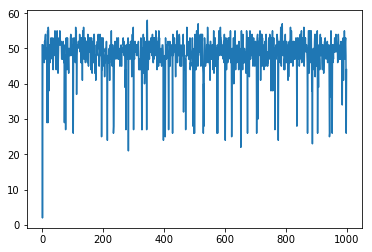

In [188]:
plt.plot(pairwise_dist2[1][:1000])
plt.show()

In [138]:
pairwise_dist -= np.diag(np.ones(6364)*1000000)

In [137]:
np.min(pairwise_dist[6])

257.0

In [139]:
pairwise_dist

array([[    0.,  1205.,  1105., ...,   929.,  1076.,   677.],
       [ 1205.,     0.,  1060., ...,   968.,   677.,   577.],
       [ 1105.,  1060.,     0., ...,   986.,  1058.,  1105.],
       ..., 
       [  929.,   968.,   986., ...,     0.,   929.,   929.],
       [ 1076.,   677.,  1058., ...,   929.,     0.,   400.],
       [  677.,   577.,  1105., ...,   929.,   400.,     0.]])

In [10]:
def spacers_dist(sp1, sp2):
    if len(sp1) < len(sp2):
        sp_short = sp1
        sp_long = sp2
    else:
        sp_short = sp2
        sp_long = sp1
    
    min_diff = 100
    for i in range(len(sp_long) - len(sp_short) +1):
        curr_diff = compare_spacer_parts(sp_short, sp_long[i:i+len(sp_short)])
        if curr_diff < min_diff:
            min_diff = curr_diff
            
    return min_diff
    

In [13]:
spacers_dist("ACT", "ATC")

2

In [12]:
def compare_spacer_parts(sp1, sp2):
    diff = 0
    for (s1, s2) in zip(sp1, sp2):
        if s1 != s2:
            diff += 1
            
    return diff

In [179]:
def pairs_dist(pair1, pair2, comparator):
    return (comparator(pair1[0], pair2[0])+1) + (comparator(pair1[1], pair2[1]) + 1)

In [180]:
pairs_dist(['asd','asd'], ['xasw', 'brt'], spacers_dist)

6

In [181]:
l = len(pairs_array)

pairwise_dist2 = np.zeros((l,l))
for i in tqdm.tqdm(range(l)):
    for j in range(l):
        d = pairs_dist(pairs_array[i], pairs_array[j], spacers_dist)
        pairwise_dist2[i][j] = d
        pairwise_dist2[j][i] = d

100%|██████████| 6364/6364 [11:49<00:00, 10.14it/s]


In [29]:
import matplotlib.pyplot as plt

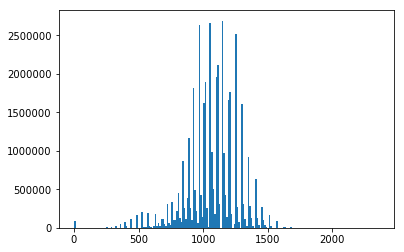

In [142]:
plt.hist(pairwise_dist.flatten(), bins=200)
plt.show()

# ГШПСДЙЛРЮ

In [217]:
from future import _division_

ImportError: cannot import name _division_

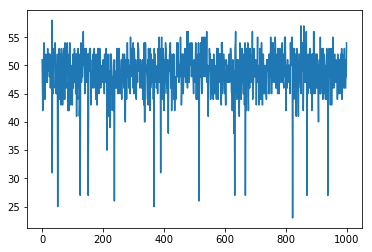

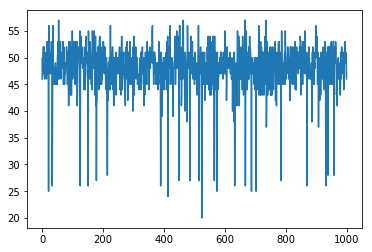

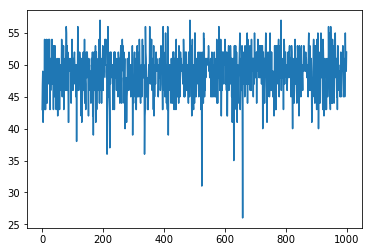

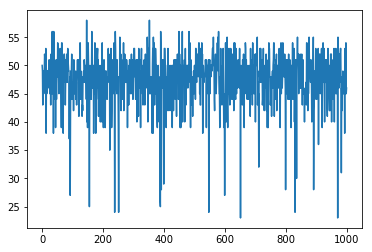

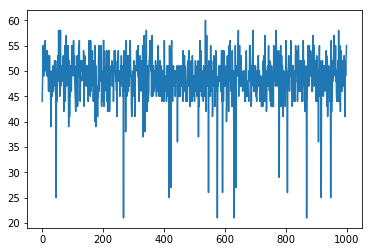

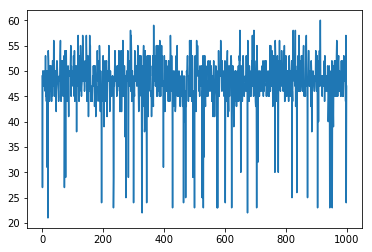

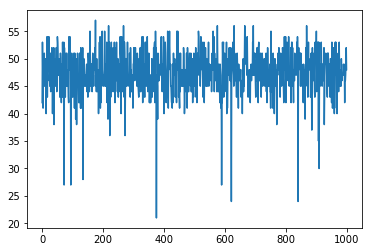

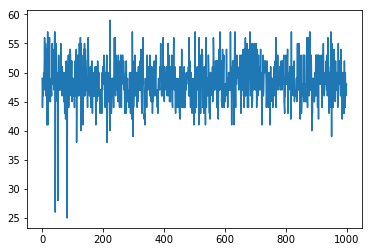

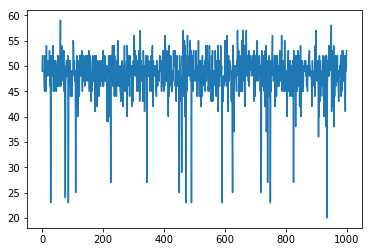

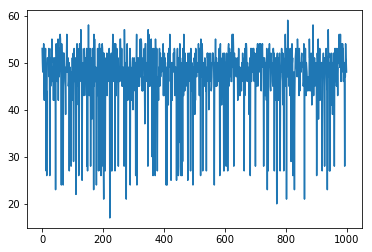

In [207]:
for i in range(10):
    plt.plot(pairwise_dist2[4001+i][:1000])
    plt.show()

In [211]:
(pairwise_dist2[0] < 30).sum()
print (pairwise_dist2[0] > 30).sum()

304
6053


In [212]:
k = 124
print (pairwise_dist2[k] < 30).sum()
print (pairwise_dist2[k] > 30).sum()

82
6278


In [220]:
304 / 6053.

0.05022302990252767

In [221]:
m0 = np.zeros(6463)

for i, p in enumerate(pairwise_dist2):
    if (p < 40).sum() / float((p >= 40).sum()) > 0.01:
        m0[i] = 1

In [223]:
m0[:100]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.])

In [225]:
p_f = pairwise_dist2[m0.astype(bool)]

/Users/rykachevskiy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 6364 but corresponding boolean dimension is 6463
  if __name__ == '__main__':


In [230]:
pf = p_f[:, m0.astype(bool)]

/Users/rykachevskiy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 6364 but corresponding boolean dimension is 6463
  if __name__ == '__main__':


(5678, 5678)

In [233]:
cluster_mask = np.zeros(5678)
curr_dist = np.ones(5678) * 100

In [249]:
cn = 1
i = 0
while i < 5678:
    if cluster_mask[i] == 0:
        p = pf[i]
        
        for j in range(5678):
            if p[j] < 50 and curr_dist > p[j]:
                cluster_mask[j] = cn
                curr_dist = p[j]
        
        cn += 1
    
    i += 1

In [250]:
cluster_mask[:100]

array([   1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,    9.,
         10.,   11.,  123.,   12.,  146.,   13.,   14.,    2.,   97.,
        100.,   58.,  110.,   15.,   16.,   14.,   17.,    3.,   18.,
         99.,  134.,   19.,   26.,   20.,  127.,  136.,   71.,   98.,
          9.,   21.,  100.,   22.,  146.,  139.,   23.,   24.,   25.,
         67.,   67.,   26.,   23.,   27.,  134.,   28.,   10.,  133.,
         29.,   73.,  129.,  114.,   12.,  110.,   27.,  109.,   30.,
        115.,   31.,  126.,    2.,   46.,   34.,   32.,   22.,  140.,
         12.,   45.,   96.,  113.,   33.,   21.,   34.,   35.,   36.,
        109.,   30.,   52.,   42.,   65.,   37.,   38.,   39.,    3.,
        110.,  134.,   40.,   22.,   78.,   41.,   25.,   50.,  138.,  145.])

In [251]:
set(cluster_mask)

{1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

In [252]:
cluster_mask[87]

38.0

In [254]:
pairs_array[m0.astype(bool)][cluster_mask == 1]

/Users/rykachevskiy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 6364 but corresponding boolean dimension is 6463
  if __name__ == '__main__':


array([['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'TCCCCCTTAATTGCTCTCAAAAGATTTGATC'],
       ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'ACTCTGGCGGCGGCGCAGGCGGATATCGCGA'],
       ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'AGTTCGACCCTACTCAGGCCGGACTATGGCC'],
       ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'TACGCGCAGAAAAAAAGGATCTCAAGAAGAT'],
       ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'TGTGCCCGACTGCGTGCCGCGTCAAGCGCCT'],
       ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'GCTGACCTGTCGAATCCGTATAGCCGCCGTT'],
       ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'ACTCACATTAATTGCGTTGCGCTCACTGCCC'],
       ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'AAACTCTGGGCGCTCGAATGGCTGTCCTGTT'],
       ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'TACGCCAGCCACCTGCTTCGCCAGCCGTTCG'],
       ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'ATCAGTGATATCCAACATTGCGGAGCTAAAC'],
       ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
        'ATTTGTCGCCGTATGAGTTTTACGCGCCGTC'],
       ['GACAGAACGGCCTCAGTAGTCTC

# From muchnik


In [430]:
def find_closest(matrix):
    flatten_pos = np.argmin(matrix + np.diag(np.ones(matrix.shape[0])*100000))
    return flatten_pos / matrix.shape[0], flatten_pos % matrix.shape[0]

In [424]:
def merge_sets(set1, set2):
    for el in set2:
        set1.add(el)

In [425]:
def merge(clusters, matrix, i, j):
    for k in range(matrix.shape[0]):
        if k != i and k != j:
            matrix[i][k] = (matrix[i][k]*len(clusters[i]) + matrix[j][k]*len(clusters[j])) / (len(clusters[i]) +len(clusters[j]))
        
    merge_sets(clusters[i], clusters[j])
    del clusters[j]
    
    matrix[:, i] = matrix[i] 
    
    return np.vstack((np.hstack((matrix[0:j, 0:j], matrix[0:j, j+1:])), np.hstack((matrix[j+1:, 0:j], matrix[j+1:, j+1:])) ))

In [426]:
n = 4
matrix = np.ones((n, n ))
matrix[1][0] += 1
matrix[2][0] += 3
matrix[0][1] += 1
matrix[0][2] += 3
matrix -= np.diag(np.ones(n))
#np.random.random((n, n))

clusters = ([set([x]) for x in range(n)])

In [420]:
matrix = merge(clusters, matrix, 0, 1)

In [438]:
matrix

array([[ 0.,  2.],
       [ 2.,  0.]])

In [439]:
clusters

[{0, 3}, {1, 2}]

In [436]:
print i, j

1 2


In [435]:
i, j = find_closest(matrix)

In [437]:
matrix = merge(clusters, matrix, i, j)

________

In [444]:
pairwise_dist = pairwise_dist / 1000

In [447]:
n = pairwise_dist.shape[0]

In [448]:
clusters = ([set([x]) for x in range(n)])

In [453]:
pairwise_dist_copy = pairwise_dist.copy()

In [456]:
for i in tqdm.tqdm(range(n-100)):
    i, j = find_closest(pairwise_dist_copy)
    pairwise_dist_copy = merge(clusters, pairwise_dist_copy, i, j)

100%|██████████| 6264/6264 [31:51<00:00,  3.28it/s] 


In [467]:
for num in clusters[0]:
    print pairs[num]

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC TCCCCCTTAATTGCTCTCAAAAGATTTGATCC

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC CTGTTTTCGCAAATCTATGGACTATTGCTATT

TCGAACCTGTTTTTCTTAGTACGCGCAACGTC TATGAGCTTCAGTAAGCCAGCGTGGTTCGCT

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC TGGCTCTGCAACAGCAGCACCCATGACCACGT

GTCACCAACATTTTCGCCGTTCAGGCCCGCAG CAATCTGGGCGACCGGTCATCATTGCTTCGATG

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC CTGTTTTCGCAAATCTATGGACTATTGCTATT

GACAGAACGGCCTCAGTAGTCTCGGCAGGCTC GGAGCGGGAAGGTCATACCGTCAACAACGCAC

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC CTGTTTTCGCAAATCTATGGACTATTGCTATT

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC CTGTTTTCGCAAATCTATGGACTATTGCTATT

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC GAAAATCAGGTTCAGGCGGTCGAGGTAA

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC CTGTTTTCGCAAATCTATGGACTATTGCTATT

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC CTGTTTTCGCAAATCTATGGACTATTGCTATT


In [491]:
lengths = []
for i in clusters:
    lengths.append(len(i))
    
lengths = np.array(lengths)

In [492]:
lengths

array([395, 261, 114, 173,  49, 135,  16,  60, 179, 274,  52, 725, 593,
         4,  22, 156,  28,  46,  21,  45,  52, 223,  40,  12,  18,  68,
       129,  15,  33,  90,  21,  29,  30,  48,   8,  13,  16,  20,   6,
        30,  25,  10,  48,  34,  46,  46,  59,  12, 163,  22,  16,  52,
       270,  85,  26, 160,  58,   4,  10,  11,  28,  22,  39,   6,   3,
        25,  87,   8,  66,  19, 111,  40,  65,  19,  21,  37,  11,  46,
        36,  23,   4,  10,   6,   9,   3,  30,  36,  20,  21,  21,  23,
         6,  16,   7,   2,   5,  14,   8,   3,   2])

In [518]:
sorted_lens = np.argsort(lengths)[::-1]

In [525]:
sorted_lens[:19]

array([11, 12,  0,  9, 52,  1, 21,  8,  3, 48, 55, 15,  5, 26,  2, 70, 29,
       66, 53])

In [526]:
np.sort(lengths)[::-1][:19]

array([725, 593, 395, 274, 270, 261, 223, 179, 173, 163, 160, 156, 135,
       129, 114, 111,  90,  87,  85])

In [529]:
clusters_cut = np.array(clusters)[sorted_lens[:19]]

### avrg spacers dist

In [489]:
spacers_dist(pairs_array[0][0], pairs_array[5000][0])

20

In [534]:
def clusters_dist(cluster1, cluster2):
    dist = 0
    for pn1 in cluster1:
        for pn2 in cluster2:
            pairs_array[pn1]
            dist += float(spacers_dist(pairs_array[pn1][1], pairs_array[pn2][0])) / (len(clusters[i])) / (len(clusters[j])) 
            
    return dist
            

In [536]:
cluster_pairwise_distances = np.zeros((19,19))

for i, cl1 in tqdm.tqdm(enumerate(clusters_cut)):
    for j, cl2 in enumerate(clusters_cut):
        cluster_pairwise_distances[i][j] = clusters_dist(cl1, cl2)
        

19it [04:06,  5.44s/it]


In [538]:
np.min(cluster_pairwise_distances)

0.90315752747571021

In [552]:
cluster_pairwise_distances_copy = cluster_pairwise_distances.copy()
cluster_pairwise_distances_copy += np.diag(np.ones(19) * 10000)

In [554]:
x_arr = []
y_arr = []
for i in range(19):
    print np.min(cluster_pairwise_distances_copy)
    min_pos = np.argmin(cluster_pairwise_distances_copy)
    x = min_pos / 19
    y = min_pos % 19
    x_arr.append(x)
    y_arr.append(y)
    cluster_pairwise_distances_copy[x][y] += 10000

0.903157527476
1.0568657324
2.62789327964
2.71001258495
2.76038576581
2.96131879224
3.32558797524
3.50755610326
3.65679045093
3.86976261513
3.88799845887
4.628125602
4.76914090836
4.81003181733
4.84213402169
6.99775164441
7.42278652582
7.72385928316
7.77513183675


In [555]:
x_arr

[11, 12, 11, 9, 12, 9, 11, 12, 15, 15, 8, 11, 12, 15, 8, 11, 3, 3, 12]

In [556]:
y_arr

[12, 11, 9, 11, 9, 12, 15, 15, 11, 12, 11, 8, 8, 9, 12, 3, 11, 12, 3]

In [546]:
cluster_pairwise_distances

array([[  6.71969620e+01,   8.87773801e+01,   1.43553276e+02,
          5.88963781e+01,   2.26043968e+02,   7.55292077e+01,
          5.59118829e+02,   1.18019325e+02,   3.92501662e+01,
          2.33636145e+01,   1.19078140e+02,   8.33768311e+00,
          8.71700216e+00,   1.19468228e+03,   1.97699425e+02,
          2.78189873e+01,   1.27704702e+02,   5.41826637e+01,
          1.60069560e+02],
       [  9.28508075e+01,   1.13920744e+02,   1.81003663e+02,
          8.34667464e+01,   4.79333021e+01,   9.81034483e+01,
          6.96385536e+02,   1.61696743e+02,   5.39769901e+01,
          2.82823503e+01,   1.57390805e+02,   1.06156533e+01,
          1.11228767e+01,   1.64077203e+03,   2.68229537e+02,
          3.57993663e+01,   1.64590449e+02,   1.02618607e+02,
          1.88341908e+02],
       [  1.25252054e+02,   1.70120589e+02,   2.70440674e+02,
          1.17278014e+02,   3.89515933e+02,   1.46103184e+02,
          1.05502029e+03,   2.26964035e+02,   7.30424385e+01,
          4.2244

In [513]:
for t in range(100):
    print t, clusters_dist(0, t)

0 22.526178497
1 21.8102526795
2 21.5235842772
3 21.8117216653
4 21.906122449
5 21.6580215659
6 22.3042721519
7 21.8582700422
8 21.9564952974
9 21.3707567218
10 21.5120253164
11 19.6948057617
12 21.6097850449
13 21.7816455696
14 21.5823935558
15 21.5315806556
16 21.6582278481
17 21.8829939461
18 22.3406871609
19 21.5974120956
20 22.0275559883
21 21.8465913606
22 22.1691772152
23 22.0156118143
24 21.8396624473
25 22.2834326136
26 21.5807280934
27 22.0742616034
28 21.7398542386
29 22.3635161744
30 22.2169981917
31 21.7992143169
32 21.7134177215
33 22.3502637131
34 22.4810126582
35 20.7162609542
36 22.2155063291
37 21.9086075949
38 22.235443038
39 22.1610126582
40 21.8687594937
41 21.4397468354
42 21.4483122363
43 22.1894266567
44 21.9989543203
45 21.833736929
46 22.2722591719
47 22.19092827
48 20.4945095907
49 21.9289988493
50 22.2348101266
51 21.688315482
52 20.4016502578
53 20.9960089352
54 21.494157741
55 22.0027373418
56 23.1538629419
57 22.0183544304
58 21.813164557
59 21.512543153


In [542]:
for x in clusters[11]:
    print pairs_array[x]

['GGGCGCACGGAATACAAAGCCGTGTATCTGCT' 'TGGCTCTGCAACAGCAGCACCCATGACCACG']
['ACGTGCGCCTGTCGCGTTGGCGGCACTTCATT' 'TGGCTCTGCAACAGCAGCACCCATGACCACG']
['GGGCGCACGGAATACAAAGCCGTGTATCTGCT' 'TGGCTCTGCAACAGCAGCACCCATGACCACG']
['TTTTGCACAACATGGGGGATCATGTAACTCGC' 'TGGCTCTGCAACAGCAGCACCCATGACCACG']
['GGTGTTCCGTTAATATCGATGGCGACGTAACT' 'TGGCTCTGCAACAGCAGCACCCATGACCACG']
['CTGTTTTCGCAAATCTATGGACTATTGCTATT' 'GGGCGCACGGAATACAAAGCCGTGTATCTGC']
['GGGCGCACGGAATACAAAGCCGTGTATCTGCT' 'TACCGGTACCAGCTCAACCGCAACCCCATCA']
['TCCGTCCACCCTGATAGCCGCCCTTGTGATCC' 'TGGCTCTGCAACAGCAGCACCCATGACCACG']
['GGGCGCACGGAATACAAAGCCGTGTATCTGCT' 'TTGCTCTGCAACAGCAGCACCCATGACCACG']
['TGTAAAAATTGATTTTCATATTGCTCTAATTG' 'TGGCTCTGCAACAGTAGCACCCATGACCACG']
['GAATGATCCCAAATTTGGGTTACAGAACCAGT' 'CGTCCCCGGAGTTCTGTCCAGCAACGACAAC']
['CTGTTTTCGCAAATCTATGGACTATTGCTATT' 'GGGCGCACGGAATACAAAGCCGTGTATCTGC']
['GGGCGCACGGAATACAAAGCCGTGTATCTGCT' 'TTTTACAGTGTCAACAATCGTCCCCTGATTG']
['GAATGATCCCAAATTTGGGTTACAGAACCAGT' 'GAGTAATCATGCCTTAATAGACCCCATCGTC']
['AGCC

In [541]:
for x in clusters[12]:
    print pairs_array[x]

['CCCATTCCAATTGATACTCATACGTTGTT' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['ACGATGGCGATGCGTGAGAAAGGGGGTCGATA' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['ATAGACCCCGAACAACAATACGCGCAAACCGA' 'ATAACCTGTTTAACCAGGCGACGGGTTTCCA']
['CAAGTGATATCCATCATCGCATCTAGTGCGCC' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['GAAATGCTGGTGAGCGTTAATGCCGCAAACAC' 'ATTACGCCTTTTTGCGATTGCCCGATTTTTG']
['CCGGGGGATAATGTTACGGTCATGCGCCCCC' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['TGGCTCTGCAACAGCAGCGCCCATGACCACGT' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['AAGTAATCATGCCTTTATAGACCCCATCGTCA' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['TGGCTCTGCAACAGCAGCACCCATGACCACGT' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['GTAGTCCATCATTCCACCTATGTCTGAACTCC' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['GAAATGCTGGTGAGCGTTAATGCCGCAAACAC' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['AGTGGCAGGCCGGTAATATGAAAACGACAGAG' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['TAAGCCGTGACGCGGGTCGCCGCTGGCGTCAA' 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTG']
['CGGGGGGATAATGTTTACGGTCATGCGCCCCC' 'TCCTCGTCGTACCCTGTTCCCCTGGTTACTG']
['GCGACCGC

# from another

In [255]:
import pandas as pd

In [262]:
pd.to_datetime("2017-09-15 12:38:00").value / 1000000

1505479080000

In [265]:
pd.to_datetime("2017-09-18T08:43:50.732").value / 1000000

1505724230732

In [266]:
pd.to_datetime("2017-09-09T01:04:03").value / 1000000

1504919043000

In [267]:
pd.to_datetime("2017-09-14T08:12:30.377").value / 1000000

1505376750377